In [5]:
from astrodb_utils.spectra import check_spectrum_plottable
from astrodb_utils.fits import add_missing_keywords, add_wavelength_keywords
from astroquery.simbad import Simbad
from specutils.manipulation import median_smooth
from specutils import Spectrum, SpectralRegion
from specutils.manipulation import extract_region
from astropy.io import fits
import astropy.units as u
import os
import pandas as pd
import numpy as np
from specutils import Spectrum1D, Spectrum
from astropy.wcs import WCS
import matplotlib.pyplot as plt

This notebook is to plot:  
- 2 FIRE_Magellan spectra (txt format)      


In [6]:
# Paths
path = "/Users/guanying/SIMPLE db/SIMPLE-db/scripts/spectra_convert/zhang18/sty2054_supplemental_files"
output_path = "/Users/guanying/SIMPLE db/SIMPLE-db/scripts/spectra_convert/zhang18/processed_spectra"
os.makedirs(output_path, exist_ok=True)


Reading file: ULAS_J124947.04+095019.8_sdL1_FIRE_Magellan_Primeval-I.txt


/var/folders/dq/78yjnq7132j29_6kkvh6zxtw0000gn/T/ipykernel_3430/3579788761.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


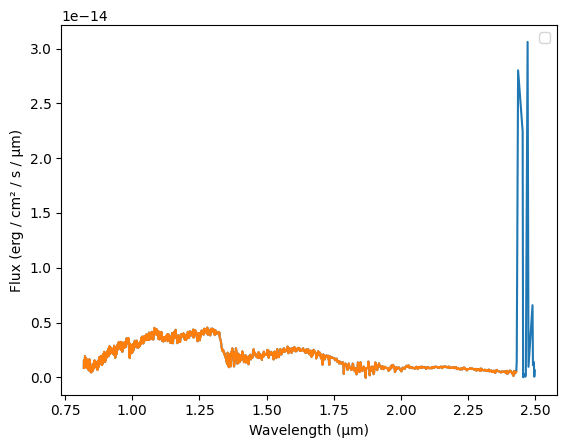

Extracted object name: ULAS J124947.04+095019.8
COPY AND PASTE THE FOLLOWING COMMANDS INTO YOUR SCRIPT 
Replace <value> with the appropriate value for your dataset 
If you're not sure of the correct value, use None 
If you started with a header object not called `header`, 
replace 'header' with the name of your header object 
Use the `astrodb_utils.fits.add_wavelength_keywords` function 
to add the SPEC_VAL, SPEC_BW, TDMID1, TDMAX1, and SPECBAND keywords 

header.set('TELAPSE', "<value>")
header.set('AUTHOR', "<value>")
header.set('VOREF', "<value>")
header.set('SPECBAND', "<value>")
header.set('APERTURE', "<value>")
Saved FITS with mask: ULAS_J124947.04+095019.8_sdL1_FIRE_Magellan_Primeval-I_SIMPLE.fits

Reading file: ULAS_J133836.97-022910.7_sdL7_FIRE_Magellan_Primeval-I.txt


/var/folders/dq/78yjnq7132j29_6kkvh6zxtw0000gn/T/ipykernel_3430/3579788761.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


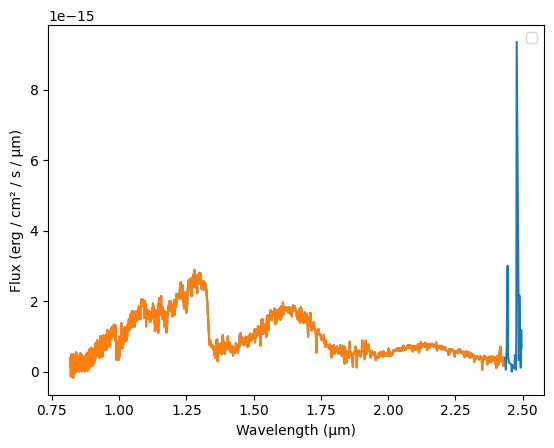

Extracted object name: ULAS J133836.97-022910.7
COPY AND PASTE THE FOLLOWING COMMANDS INTO YOUR SCRIPT 
Replace <value> with the appropriate value for your dataset 
If you're not sure of the correct value, use None 
If you started with a header object not called `header`, 
replace 'header' with the name of your header object 
Use the `astrodb_utils.fits.add_wavelength_keywords` function 
to add the SPEC_VAL, SPEC_BW, TDMID1, TDMAX1, and SPECBAND keywords 

header.set('TELAPSE', "<value>")
header.set('AUTHOR', "<value>")
header.set('VOREF', "<value>")
header.set('SPECBAND', "<value>")
header.set('APERTURE', "<value>")
Saved FITS with mask: ULAS_J133836.97-022910.7_sdL7_FIRE_Magellan_Primeval-I_SIMPLE.fits


Total files plotted: 2
Total files failed: 0


In [7]:
from datetime import date
plotted_file = 0
failed_file = 0
file_failed = []
for filename in os.listdir(path):
    if "fire" in filename.lower() and filename.endswith(".txt"):
        file_path = os.path.join(path, filename)
        
        try:
            print(f"Reading file: {filename}")
            data = np.loadtxt(file_path, comments="#", encoding="latin1")

            # column1: #w         column2:flux
            if filename == "SDSS_J134749.74+333601.7_sdL0_SDSS_Primeval-I.txt":
                wavelength = (data[:, 0] * u.AA).to(u.um)
                flux = data[:, 1] * (u.erg / (u.cm**2 * u.s * u.micron))
            else:
                wavelength = data[:, 0] * u.um
                flux = data[:, 1] * (u.erg / (u.cm**2 * u.s * u.um))

            # Create spectrum with masking
            mask = wavelength > 2.43 * u.um
            spectrum = Spectrum(
                spectral_axis=wavelength, 
                flux=flux, 
                mask=mask,
                meta={'header': fits.Header()}
            )

            # Plot to verify
            fig, ax = plt.subplots()
            ax.plot(spectrum.spectral_axis, spectrum.flux)
            ax.plot(spectrum.spectral_axis[~spectrum.mask], 
                   spectrum.flux[~spectrum.mask])
            ax.legend()
            ax.set_xlabel("Wavelength (μm)")
            ax.set_ylabel("Flux (erg / cm² / s / μm)")
            plt.show()
            plotted_file += 1

            # Add metadata to spectrum header
            header = spectrum.meta['header']
            header.set('SIMPLE', True, 'Conforms to FITS standard')
            header.set('VOPUB', 'SIMPLE Archive', 'Publication of the spectrum')

            # Object name
            object_name = " ".join(filename.split("_")[:2])
            print(f"Extracted object name: {object_name}")
            header.set('OBJECT', object_name, 'Name of the observed object')
            header.set('CONTRIB1', "Guan Ying Goh", 'Contributor')

            # Query SIMBAD for coordinates
            try:
                result = Simbad.query_object(object_name)
                if result is not None and len(result) > 0:
                    header.set("RA_TARG", result[0]["ra"], '[deg] RA')
                    header.set("DEC_TARG", result[0]["dec"], '[deg] Dec')
            except Exception as e:
                print(f"  SIMBAD query failed for {object_name}: {e}")

            # Telescope/Instrument/Date
            header["TELESCOP"] = "Magellan Baade Telescope"
            header["INSTRUME"] = "FIRE"
            header["DATE-OBS"] = "2012-05-08T00:00:00"
            header["MASKED"] = True
            header["MASKDEF"] = "wavelength > 2.43 um"
            header["BUNIT"] = str(flux.unit)
            header["DATE"] = date.today().isoformat()

            # Add wavelength keywords
            add_wavelength_keywords(header, spectrum.spectral_axis)
            add_missing_keywords(header, format="simple-spectrum")

            # Save FITS using specutils (automatically handles mask)
            fits_filename = filename.replace(".txt", "_SIMPLE.fits")
            fits_path = os.path.join(output_path, fits_filename)
            spectrum.write(fits_path, format='tabular-fits', overwrite=True)
            print(f"Saved FITS with mask: {fits_filename}\n")

        except Exception as e:
            print(f"Could not process {filename}: {e}")
            failed_file += 1
            file_failed.append(filename)

print(f"\nTotal files plotted: {plotted_file}")
print(f"Total files failed: {failed_file}")
if file_failed:
    print("Failed files:", file_failed)

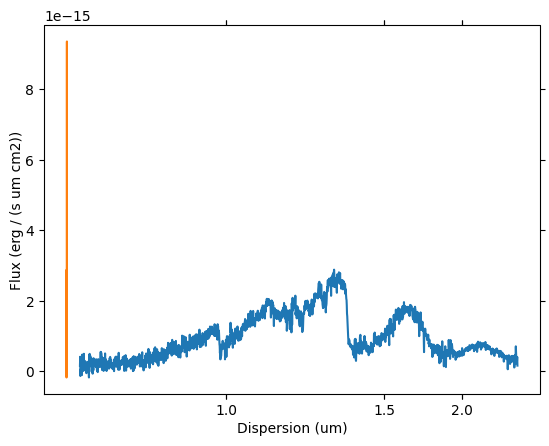

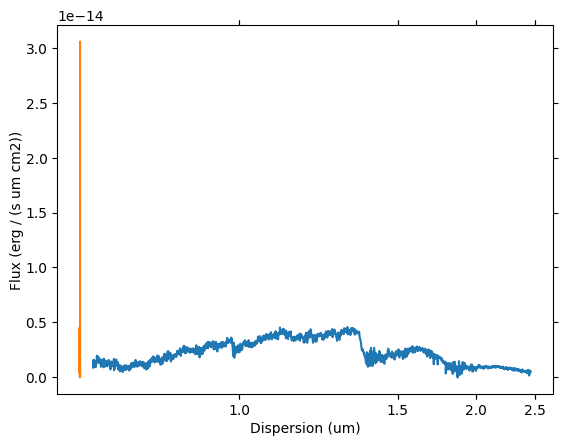

In [8]:
# check new FIRE fits files
fits_files = [
    "ULAS_J133836.97-022910.7_sdL7_FIRE_Magellan_Primeval-I_SIMPLE.fits",
    "ULAS_J124947.04+095019.8_sdL1_FIRE_Magellan_Primeval-I_SIMPLE.fits"
]
for fits_file in fits_files:
    fits_path = os.path.join(output_path, fits_file)
    spectrum = Spectrum.read(fits_path)
    spectrum.plot()
    check_spectrum_plottable(spectrum, show_plot=True)
    